In [43]:
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix



In [8]:
df = pd.read_csv('invoice_data.csv') 
df.head()

,Sno,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,26:00.0,2.55,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,26:00.0,3.39,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,26:00.0,2.75,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,26:00.0,3.39,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,26:00.0,3.39,17850,United Kingdom


In [9]:
# Assuming the dataset is loaded into df (same as before)
df_filtered = df[['InvoiceNo', 'StockCode', 'Quantity']]
df_filtered = df_filtered[df_filtered['Quantity'] > 0]

In [10]:
transactions = df_filtered.groupby('InvoiceNo')['StockCode'].apply(set).tolist()


In [11]:
def generate_candidates(prev_frequent_itemsets, k):
    candidates = set()
    for itemset1 in prev_frequent_itemsets:
        for itemset2 in prev_frequent_itemsets:
            if len(itemset1.union(itemset2)) == k:
                candidates.add(itemset1.union(itemset2))
    return candidates


In [12]:
def calculate_support(candidates, transactions):
    itemset_counts = {itemset: 0 for itemset in candidates}
    
    for transaction in transactions:
        for itemset in candidates:
            if itemset.issubset(transaction):
                itemset_counts[itemset] += 1
    
    total_transactions = len(transactions)
    itemset_support = {itemset: count / total_transactions for itemset, count in itemset_counts.items()}
    
    return itemset_support

In [13]:
def prune_itemsets(itemset_support, min_support):
    return {itemset: support for itemset, support in itemset_support.items() if support >= min_support}


In [14]:
def apriori(transactions, min_support):
    items = set(item for transaction in transactions for item in transaction)
    candidates = {frozenset([item]) for item in items}
    
    frequent_itemsets = []
    k = 1  # We start with itemsets of length 1
    
    while candidates:
        itemset_support = calculate_support(candidates, transactions)
        candidates = prune_itemsets(itemset_support, min_support)
        
        if not candidates:  # No more frequent itemsets
            break
        
        frequent_itemsets.append(candidates)
        k += 1
        candidates = generate_candidates(candidates, k)
    
    return frequent_itemsets

In [15]:
def generate_rules(frequent_itemsets, itemset_support, min_confidence):
    rules = []
    
    for itemsets in frequent_itemsets:
        for itemset in itemsets:
            subsets = [frozenset(comb) for i in range(1, len(itemset)) for comb in combinations(itemset, i)]
            
            for subset in subsets:
                antecedent = subset
                consequent = itemset - subset
                
                antecedent_support = itemset_support.get(antecedent, 0)
                rule_support = itemset_support.get(itemset, 0)
                
                if antecedent_support > 0:
                    confidence = rule_support / antecedent_support
                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, confidence, rule_support))
    
    return rules

In [16]:
min_support = 0.01  # Minimum support
min_confidence = 0.7  # Minimum confidence

# Get the frequent itemsets
frequent_itemsets = apriori(transactions, min_support)

# Calculate the support for itemsets (needed for generating rules)
itemset_support = {}
for itemsets in frequent_itemsets:
    for itemset in itemsets:
        itemset_support[itemset] = calculate_support([itemset], transactions).get(itemset, 0)

# Generate the association rules
rules = generate_rules(frequent_itemsets, itemset_support, min_confidence)

In [17]:
# Count how often itemsets appear and plot top itemsets
itemset_counts = {itemset: itemset_support[itemset] for itemsets in frequent_itemsets for itemset in itemsets}
top_itemsets = sorted(itemset_counts.items(), key=lambda x: x[1], reverse=True)[:10]


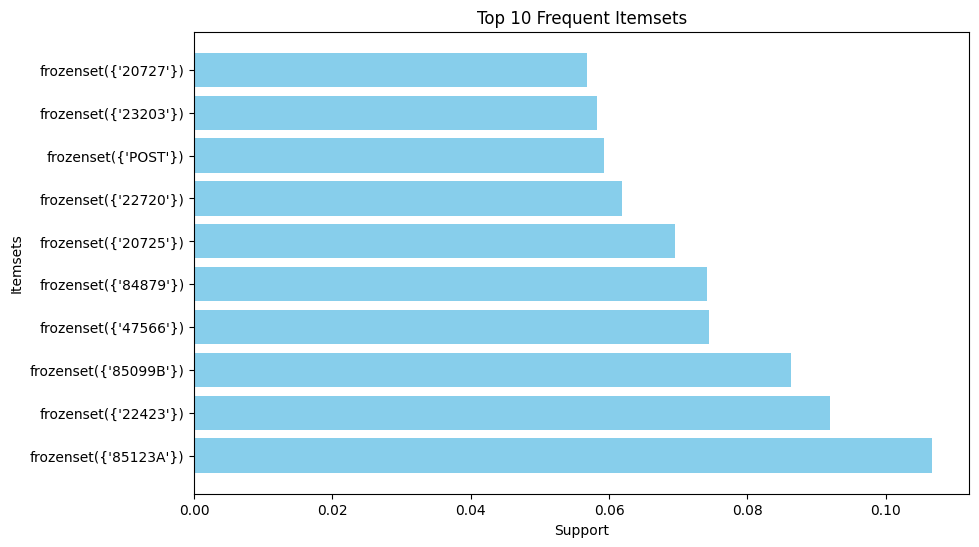

In [18]:
# Visualization of frequent itemsets
itemsets, supports = zip(*top_itemsets)
plt.figure(figsize=(10,6))
plt.barh([str(itemset) for itemset in itemsets], supports, color='skyblue')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.show()

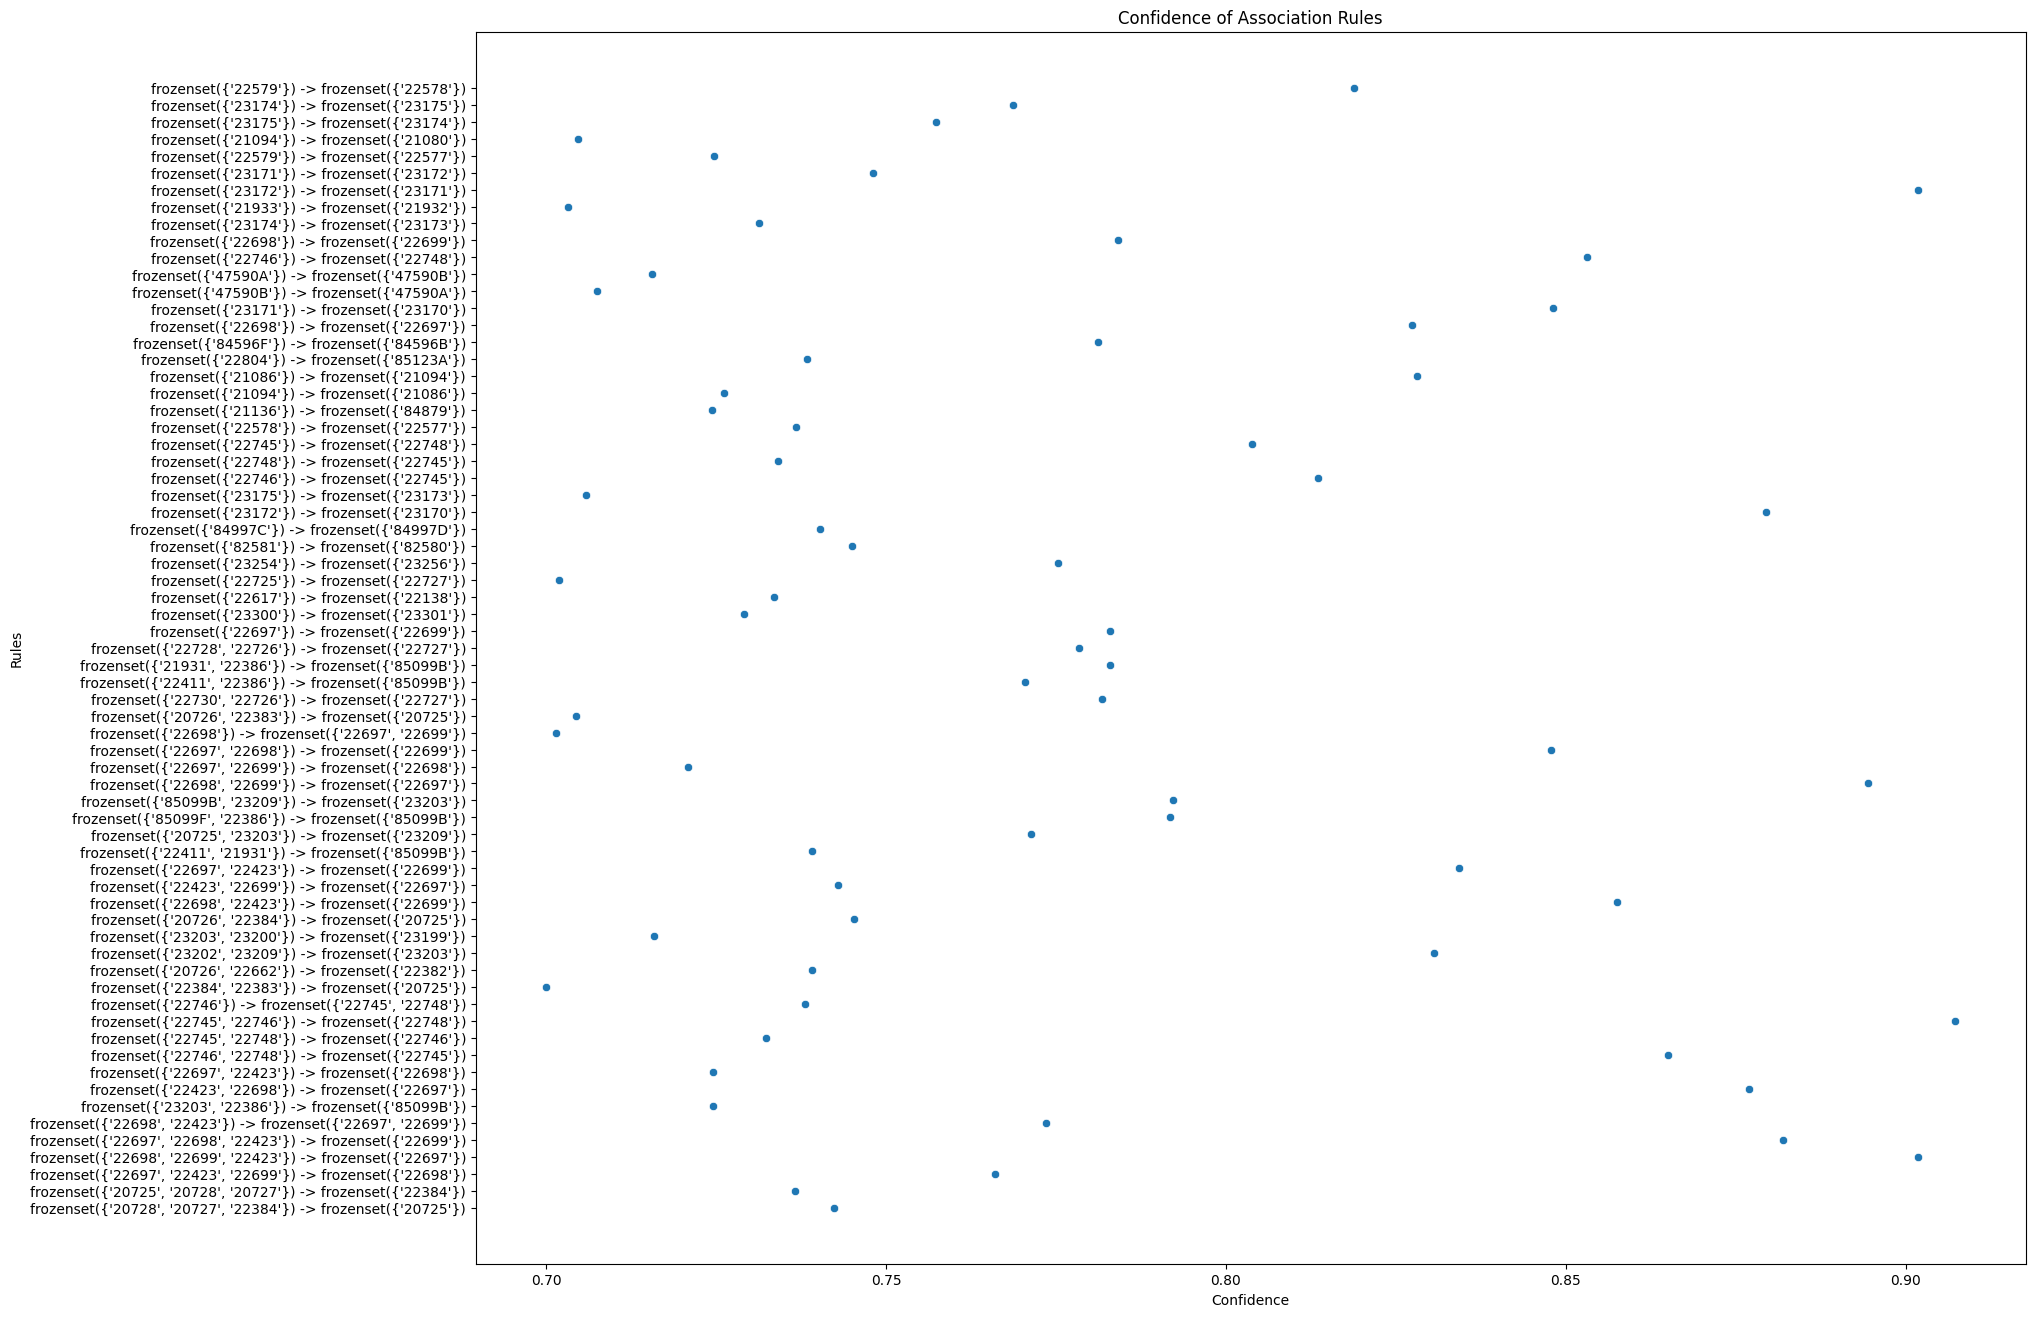

In [26]:
rule_confidences = [(rule[0], rule[1], rule[2]) for rule in rules]
if rule_confidences:
    antecedents, consequents, confidences = zip(*rule_confidences)
    plt.figure(figsize=(20,16))
    sns.scatterplot(x=confidences, y=[str(antecedent) + " -> " + str(consequent) for antecedent, consequent in zip(antecedents, consequents)])
    plt.xlabel('Confidence')
    plt.ylabel('Rules')
    plt.title('Confidence of Association Rules')
    plt.show()

C:\Users\Bhavya\AppData\Local\Temp\ipykernel_10872\3114225908.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Confidence', y='Rule', data=df_rules, palette='viridis')


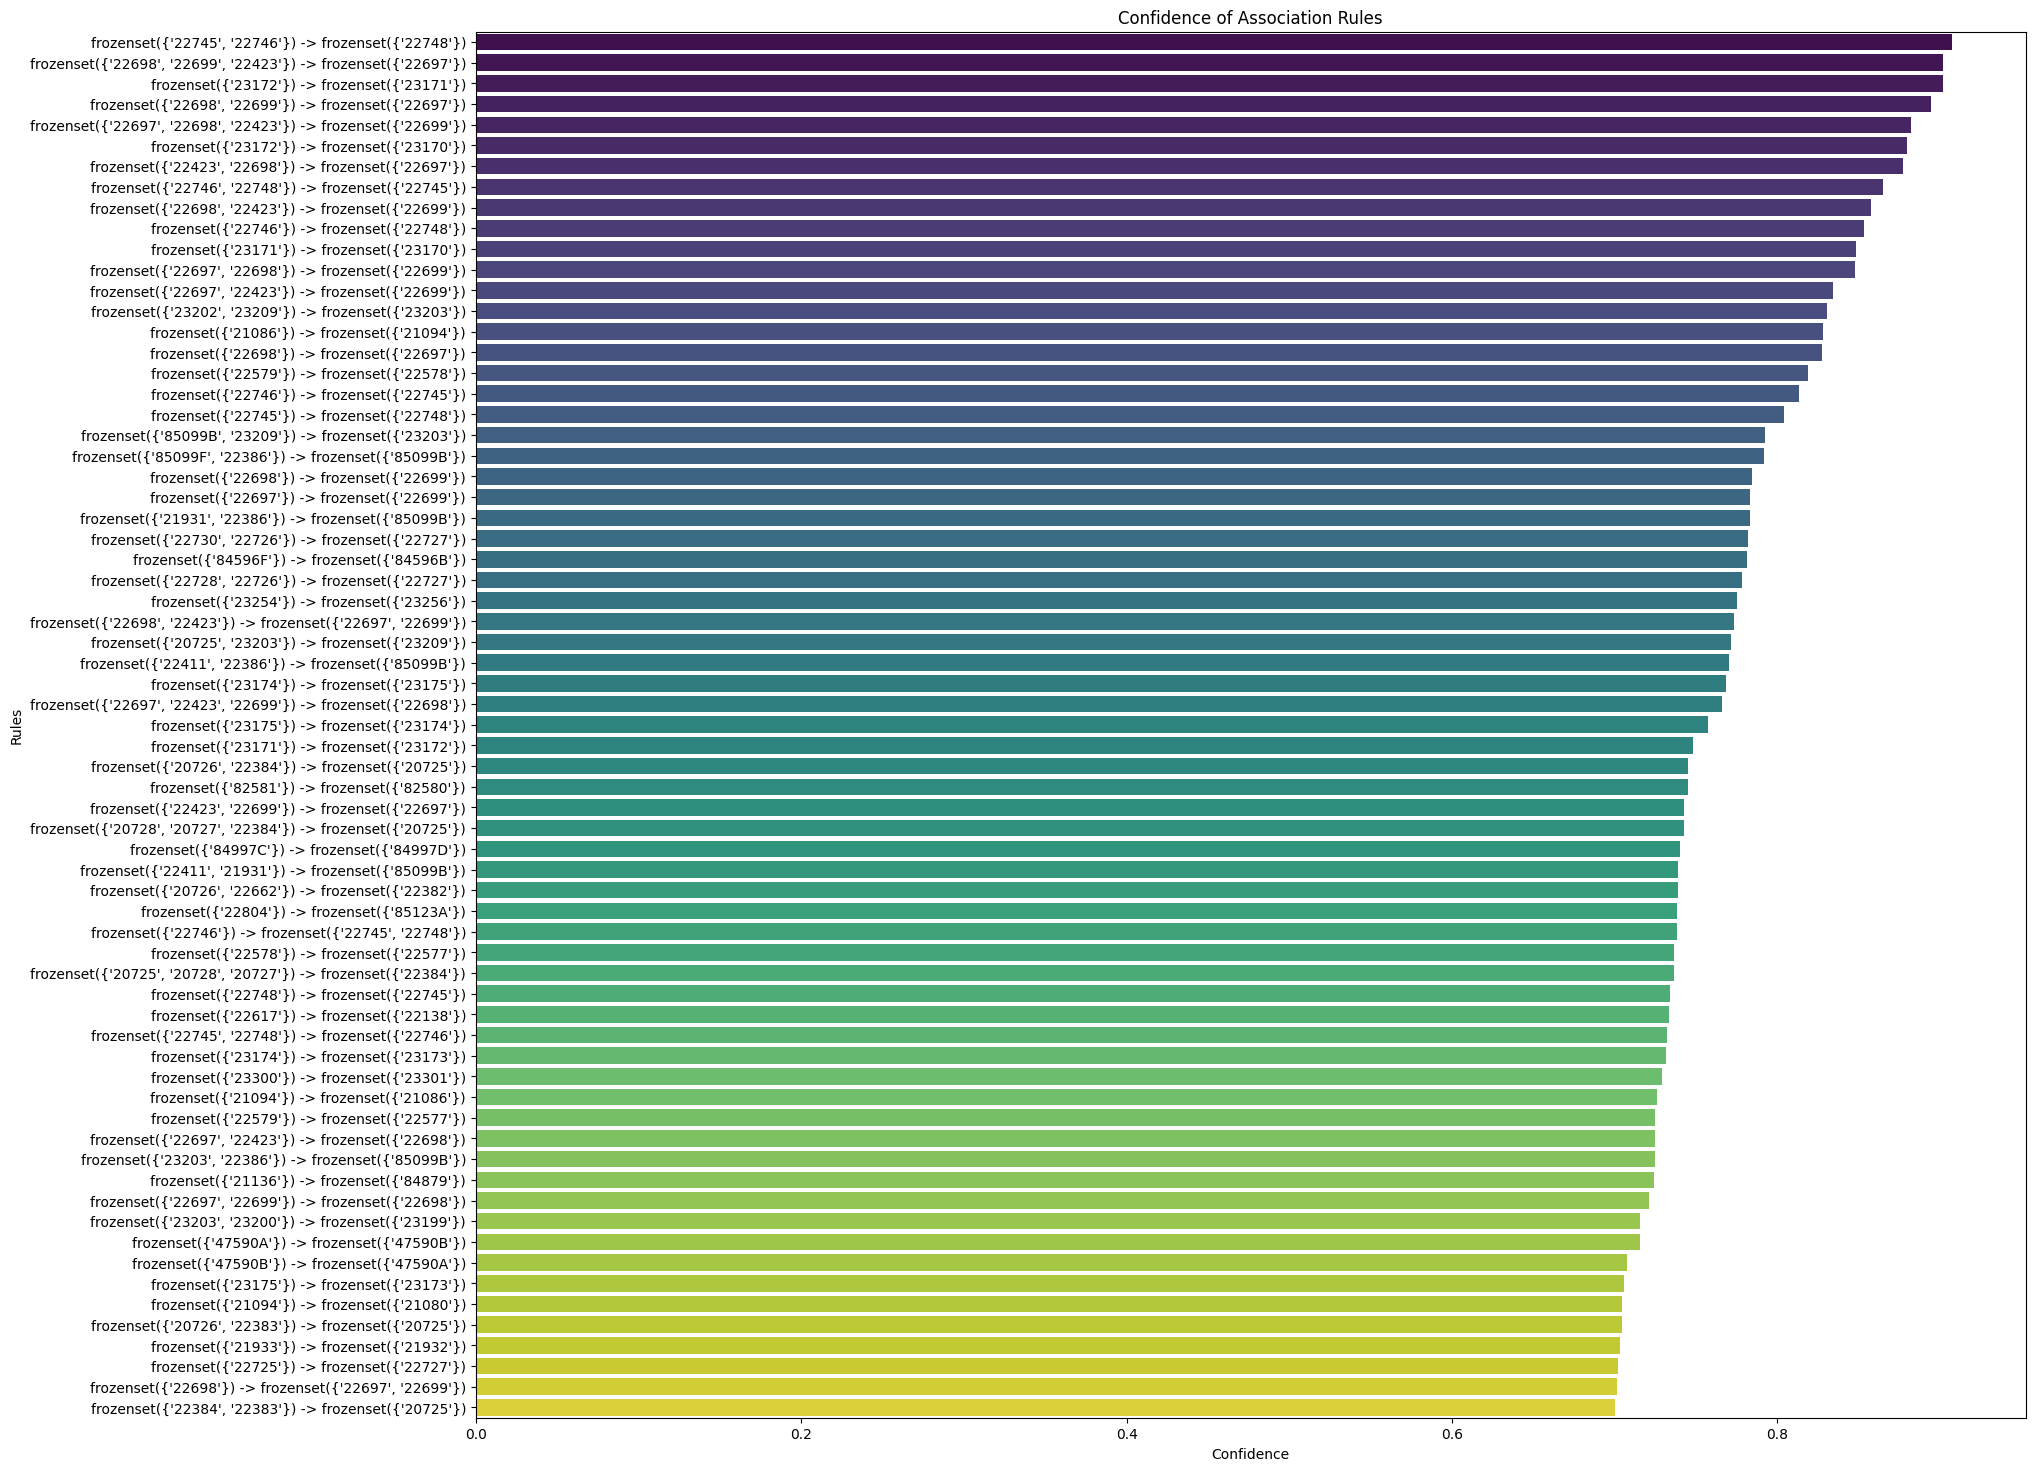

In [28]:
rule_confidences = [(rule[0], rule[1], rule[2]) for rule in rules]

if rule_confidences:
    antecedents, consequents, confidences = zip(*rule_confidences)
    
    # Combine antecedent and consequent for better readability on y-axis
    rules_str = [str(antecedent) + " -> " + str(consequent) for antecedent, consequent in zip(antecedents, consequents)]
    
    # Create a DataFrame for better visualization handling
    df_rules = pd.DataFrame({
        'Rule': rules_str,
        'Confidence': confidences
    })
    
    # Sort by confidence for better readability in the bar chart
    df_rules = df_rules.sort_values(by='Confidence', ascending=False)

    # Plot the bar chart
    plt.figure(figsize=(20,18))
    sns.barplot(x='Confidence', y='Rule', data=df_rules, palette='viridis')
    plt.xlabel('Confidence')
    plt.ylabel('Rules')
    plt.title('Confidence of Association Rules')
    plt.show()

In [30]:
# Ensure that rule_confidences contains (antecedent, consequent, confidence)
rule_confidences = [(rule[0], rule[1], rule[2]) for rule in rules]

# Extract antecedents, consequents, and confidences separately
antecedents, consequents, confidences = zip(*rule_confidences)

# Create a DataFrame with antecedents, consequents, and confidences
df_rules = pd.DataFrame({
    'Antecedent': antecedents,
    'Consequent': consequents,
    'Confidence': confidences
})

In [31]:

# Generate a target variable: 1 for high confidence, 0 for low confidence
y = [1 if confidence > 0.8 else 0 for confidence in confidences]

# Optional: You can include support or other metrics if needed, but for now, we're focusing on confidence.
# For ML model, use just the confidence as a feature
X = df_rules[['Confidence']]


In [32]:

# Display the DataFrame to check the data
print(df_rules.head())


  Antecedent Consequent  Confidence
0    (22579)    (22578)    0.818841
1    (23174)    (23175)    0.768657
2    (23175)    (23174)    0.757353
3    (21094)    (21080)    0.704615
4    (22579)    (22577)    0.724638


In [35]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Logistic Regression Model
logreg_model = LogisticRegression()

# Train the Logistic Regression model
logreg_model.fit(X_train, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg * 100:.2f}%")

# Confusion Matrix for Logistic Regression
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_logreg)

Logistic Regression Accuracy: 78.57%
Confusion Matrix for Logistic Regression:
[[11  0]
 [ 3  0]]


In [39]:
# Decision Tree Classifier Model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt * 100:.2f}%")

# Confusion Matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix for Decision Tree:")
print(conf_matrix_dt)

Decision Tree Accuracy: 100.00%
Confusion Matrix for Decision Tree:
[[11  0]
 [ 0  3]]


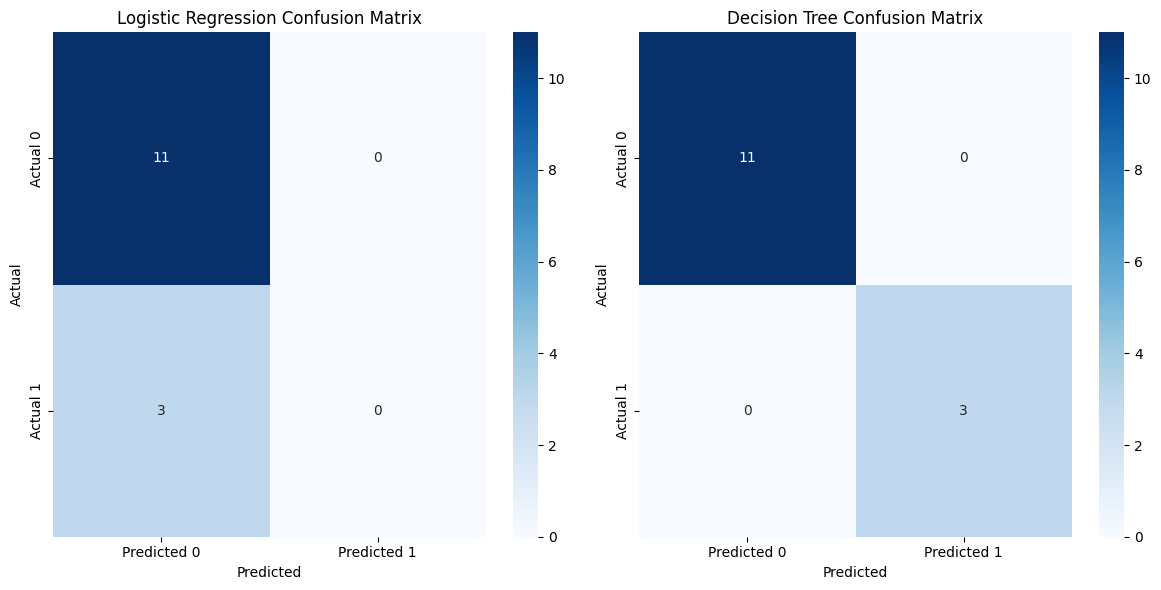

In [45]:
# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_logreg)

# Decision Tree confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Create a figure with two subplots to compare both models
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"], ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")

# Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"], ax=axes[1])
axes[1].set_title("Decision Tree Confusion Matrix")
axes[1].set_ylabel("Actual")
axes[1].set_xlabel("Predicted")

# Adjust layout for better display
plt.tight_layout()
plt.show()